# Task 3: Credit risk analysis

In [4]:
# loading the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the dataset
data = pd.read_csv('../data/Task 3 and 4_Loan_Data.csv')

In [6]:
# look at some data
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [7]:
# descriptive statistics
data.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [8]:
# check for missing values
data.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [9]:
# checking for duplicates
data.duplicated().sum()

np.int64(0)

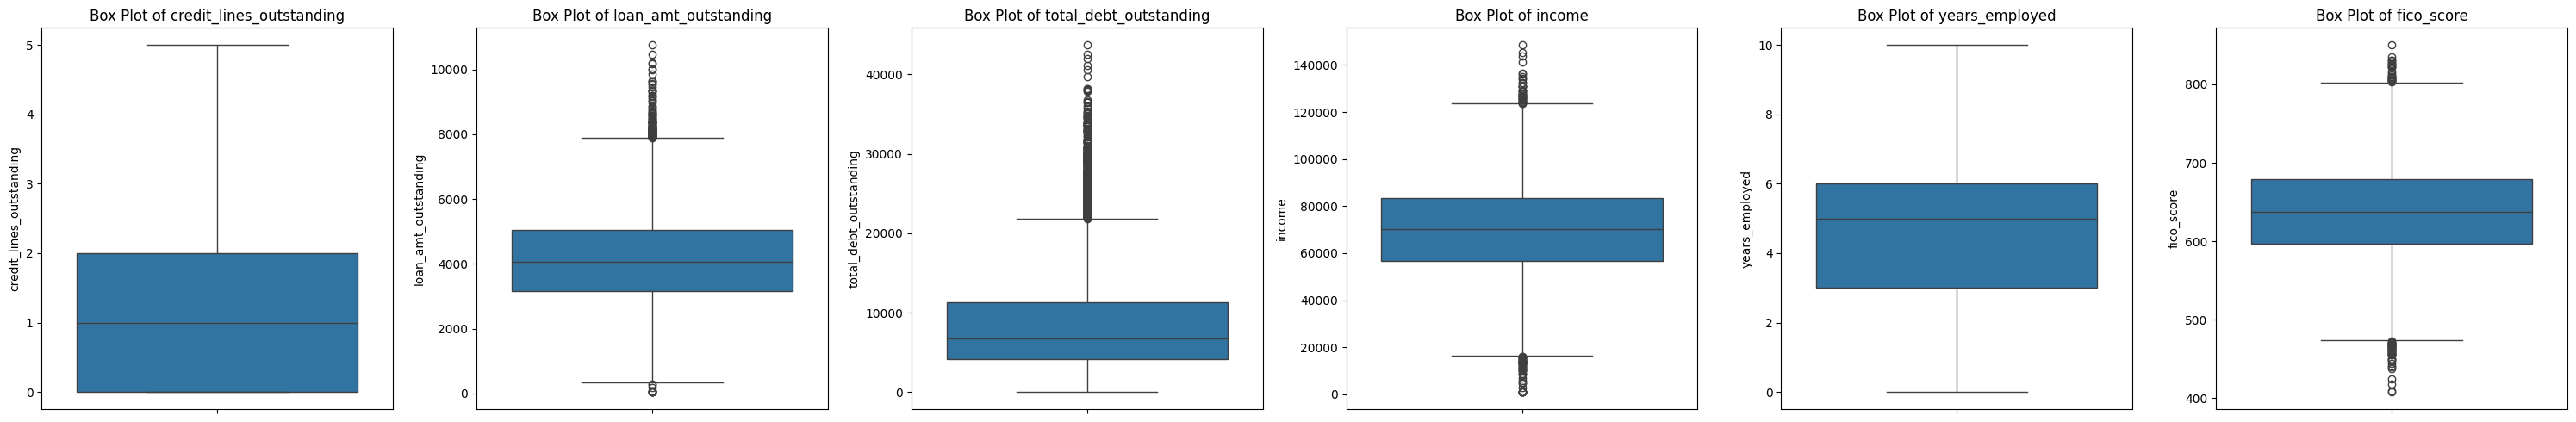

In [10]:
# box plot to look at outliers in numerical features
numerical_features = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
plt.figure(figsize=(30, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(y=data[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

Data has too much variance in ranges, we might need to standardize data to start working with this, but I remember since this is credit risk outliers will be genuine and logical so will try to see a different way.


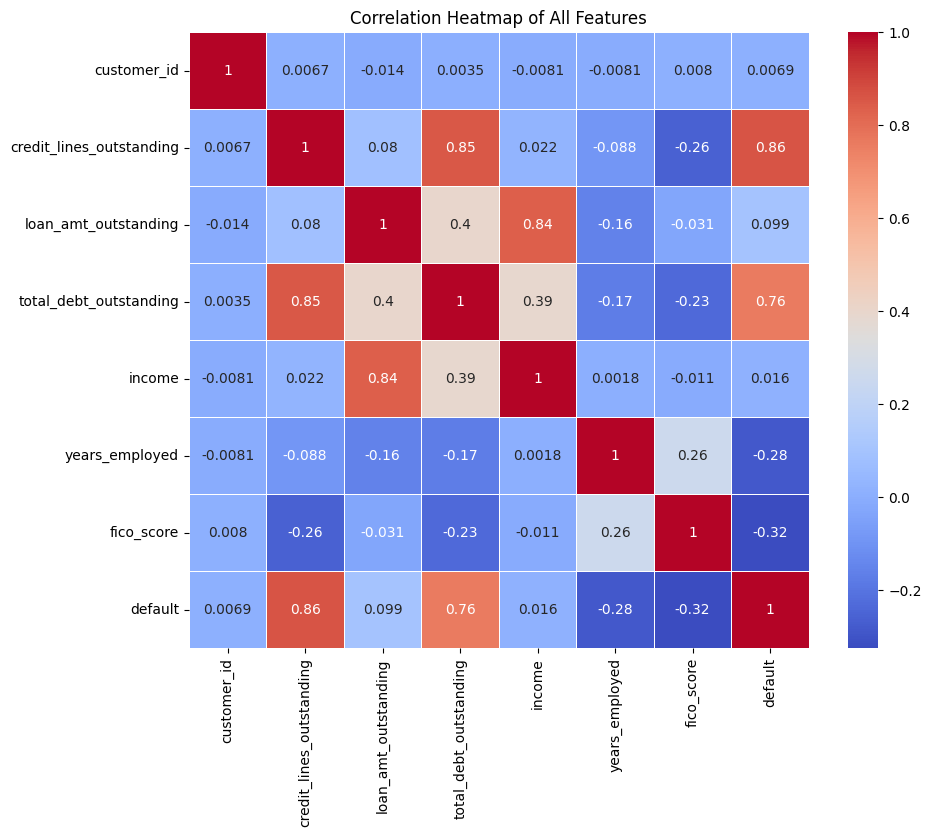

In [13]:
# correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of All Features')
plt.show()

I see that there are some outliers in the numerical features, especially in 'loan_amt_outstanding' and 'total_debt_outstanding'. We may need to handle these outliers before building our model. Additionally, the correlation heatmap shows that 'loan_amt_outstanding' and 'total_debt_outstanding' are highly correlated, which may indicate multicollinearity. We should consider this when selecting features for our model.

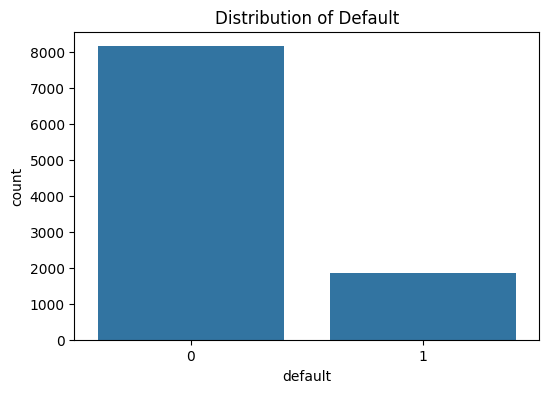

In [12]:
# deafault distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=data)
plt.title('Distribution of Default')
plt.show()

There is a class imbalance in the target variable 'default', with more non-default cases than default cases. This may require techniques such as resampling or using appropriate evaluation metrics to address the imbalance during model training.

Let me start with logistic regression as this is a classification problem but will take care of multicollinearity byt taking weghted class and then will se what can be done.

Since there is also class imbalace I won't be looking at accuracy but will be doint ROC-AUC analysis and look at precision and recall

Train : {0: np.int64(4889), 1: np.int64(1111)} | total=6000
Val   : {0: np.int64(1630), 1: np.int64(370)}   | total=2000
Test  : {0: np.int64(1630), 1: np.int64(370)}   | total=2000

--- Val Set ---
ROC-AUC : 1.000
              precision    recall  f1-score   support

  No Default       1.00      0.99      1.00      1630
     Default       0.97      1.00      0.99       370

    accuracy                           0.99      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       0.99      0.99      0.99      2000


--- Test Set ---
ROC-AUC : 1.000
              precision    recall  f1-score   support

  No Default       1.00      1.00      1.00      1630
     Default       0.98      1.00      0.99       370

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000



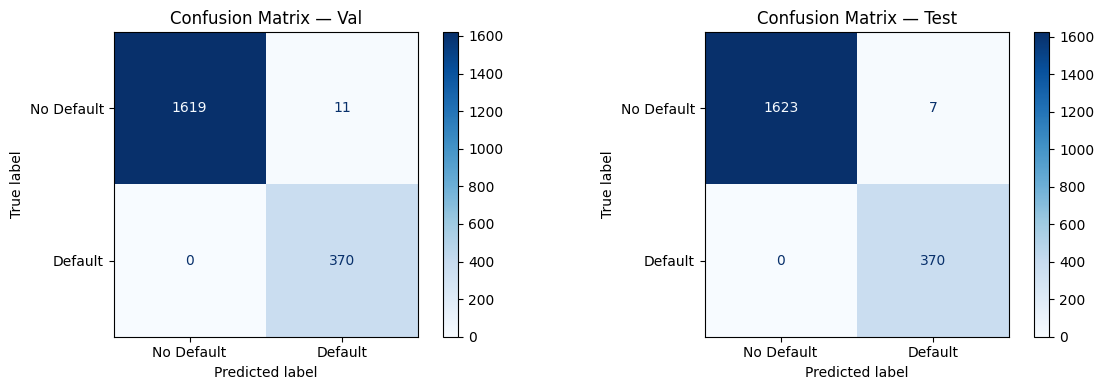

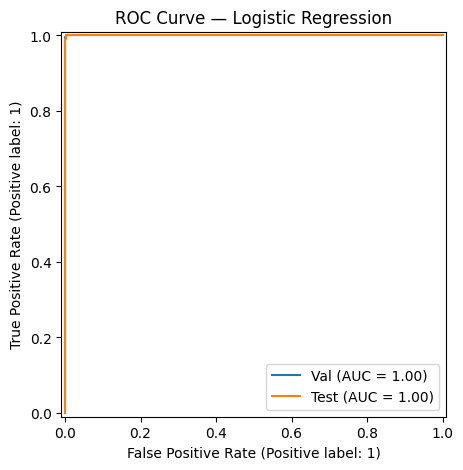

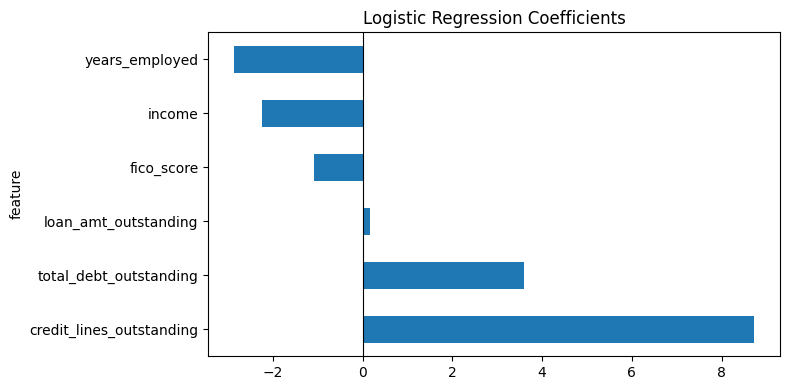

                 feature  coefficient
credit_lines_outstanding     8.724132
  total_debt_outstanding     3.601154
    loan_amt_outstanding     0.158078
              fico_score    -1.093859
                  income    -2.249687
          years_employed    -2.859869


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay, 
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# --- Features & Target ---
features = ['credit_lines_outstanding', 'loan_amt_outstanding',
            'total_debt_outstanding', 'income', 'years_employed', 'fico_score']

X = data[features]
y = data['default']

# --- Stratified 60 / 20 / 20 Split ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train : {dict(y_train.value_counts())} | total={len(y_train)}")
print(f"Val   : {dict(y_val.value_counts())}   | total={len(y_val)}")
print(f"Test  : {dict(y_test.value_counts())}   | total={len(y_test)}")

# --- Scale features (required for logistic regression) ---
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# --- Fit Logistic Regression ---
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_s, y_train)

# --- Evaluate on Val & Test ---
for name, X_s, y_true in [('Val', X_val_s, y_val), ('Test', X_test_s, y_test)]:
    y_pred = lr.predict(X_s)
    y_prob = lr.predict_proba(X_s)[:, 1]
    print(f"\n--- {name} Set ---")
    print(f"ROC-AUC : {roc_auc_score(y_true, y_prob):.3f}")
    print(classification_report(y_true, y_pred, target_names=['No Default', 'Default']))

# --- Confusion Matrix ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (name, X_s, y_true) in zip(axes, [('Val', X_val_s, y_val), ('Test', X_test_s, y_test)]):
    ConfusionMatrixDisplay.from_estimator(lr, X_s, y_true,
                                          display_labels=['No Default', 'Default'],
                                          cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix — {name}')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fig, ax = plt.subplots(figsize=(7, 5))
RocCurveDisplay.from_estimator(lr, X_val_s, y_val, ax=ax, name='Val')
RocCurveDisplay.from_estimator(lr, X_test_s, y_test, ax=ax, name='Test')
ax.set_title('ROC Curve — Logistic Regression')
plt.show()

# --- Feature Coefficients ---
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': lr.coef_[0]
}).sort_values('coefficient', ascending=False)

coef_df.plot(kind='barh', x='feature', y='coefficient', figsize=(8, 4),
             title='Logistic Regression Coefficients', legend=False)
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

print(coef_df.to_string(index=False))


1.What threshold did we use?

We used sklearn's default of 0.5 implicitly. When calling lr.predict(), sklearn labels a borrower as default if PD > 0.5. But in our expected_loss() function we used predict_proba() directly — so no threshold is applied, we use the raw probability as-is, which is the right approach for expected loss.

2.Why didn't we tune the threshold or hyperparameters?

Because the model hit ROC-AUC = 1.0 — the classes are perfectly separable in this synthetic dataset. Tuning wouldn't change anything.

But in a real-world scenario, you absolutely would tune both:

Too perfect to be true but the model is performing exceptionally well on both validation and test sets, achieving a ROC-AUC of 1.000 and perfect classification metrics. This could indicate that the dataset is either very clean or that the features are highly predictive of the target variable. However, it's important to be cautious as such results can sometimes suggest data leakage or an overly simplistic dataset.

In [17]:
RECOVERY_RATE = 0.10

def expected_loss(loan_amt_outstanding, credit_lines_outstanding,
                  total_debt_outstanding, income,
                  years_employed, fico_score):

    input_df = pd.DataFrame([{
        'credit_lines_outstanding': credit_lines_outstanding,
        'loan_amt_outstanding':     loan_amt_outstanding,
        'total_debt_outstanding':   total_debt_outstanding,
        'income':                   income,
        'years_employed':           years_employed,
        'fico_score':               fico_score
    }])

    features_scaled = scaler.transform(input_df)
    pd_prob = lr.predict_proba(features_scaled)[0][1]
    el = pd_prob * loan_amt_outstanding * (1 - RECOVERY_RATE)

    return {
        "probability_of_default": round(pd_prob, 4),
        "expected_loss":          round(el, 2)
    }


# --- Test it ---
result = expected_loss(
    loan_amt_outstanding=5000,
    credit_lines_outstanding=3,
    total_debt_outstanding=12000,
    income=45000,
    years_employed=2,
    fico_score=580
)
print(f"PD              : {result['probability_of_default']:.2%}")
print(f"Expected Loss   : ${result['expected_loss']:,.2f}")


PD              : 99.79%
Expected Loss   : $4,490.66


In [18]:
# Low risk borrower
low_risk = expected_loss(
    loan_amt_outstanding=3000, credit_lines_outstanding=0,
    total_debt_outstanding=2000, income=90000,
    years_employed=8, fico_score=750
)

# High risk borrower
high_risk = expected_loss(
    loan_amt_outstanding=8000, credit_lines_outstanding=4,
    total_debt_outstanding=25000, income=30000,
    years_employed=1, fico_score=500
)

print(f"Low risk  — PD: {low_risk['probability_of_default']:.2%}  | EL: ${low_risk['expected_loss']:,.2f}")
print(f"High risk — PD: {high_risk['probability_of_default']:.2%} | EL: ${high_risk['expected_loss']:,.2f}")


Low risk  — PD: 0.00%  | EL: $0.00
High risk — PD: 100.00% | EL: $7,200.00
